In [3]:
import geopandas as gpd
import numpy as np
import rasterio
from pyproj import Transformer
import pandas as pd

In [5]:
import matplotlib.pyplot as plt

In [3]:
np.full(5, 3.14)

array([3.14, 3.14, 3.14, 3.14, 3.14])

In [4]:
shapefile_path = "../data/land_cover/cop/CLC18_IE_wgs84/CLC18_IE_wgs84.shp"

In [5]:
gdf = gpd.read_file(shapefile_path)
gdf

,OBJECTID,ID,CODE_18,Class_Desc,Area_Ha,Shape_STAr,Shape_STLe,geometry
0,1,IE_1,111,Continuous urban fabric,3.593744e+01,3.595292e+05,3.399929e+03,"POLYGON ((-8.73762 51.74733, -8.73753 51.74732..."
1,2,IE_2,111,Continuous urban fabric,1.785159e+02,1.785928e+06,9.115961e+03,"POLYGON ((-8.46873 51.90207, -8.4685 51.90206,..."
2,3,IE_3,111,Continuous urban fabric,2.767229e+01,2.768421e+05,3.185437e+03,"POLYGON ((-7.84092 51.94764, -7.84102 51.94763..."
3,4,IE_4,111,Continuous urban fabric,4.389431e+01,4.391323e+05,3.740968e+03,"POLYGON ((-9.50588 52.0631, -9.50612 52.06227,..."
4,5,IE_5,111,Continuous urban fabric,5.020679e+01,5.022843e+05,3.335530e+03,"POLYGON ((-8.64723 52.14024, -8.64715 52.14023..."
...,...,...,...,...,...,...,...,...
18877,18878,IE_18878,522,Estuaries,5.021254e+01,5.023418e+05,5.987252e+03,"POLYGON ((-8.31413 55.09169, -8.31299 55.09124..."
18878,18879,IE_18879,522,Estuaries,1.747832e+02,1.748585e+06,1.643064e+04,"POLYGON ((-7.85675 55.15326, -7.85667 55.15326..."
18879,18880,IE_18880,522,Estuaries,8.743091e+01,8.746859e+05,9.344419e+03,"POLYGON ((-8.12393 55.15333, -8.1239 55.15333,..."
18880,18881,IE_18881,522,Estuaries,2.865799e+02,2.867034e+06,1.934943e+04,"POLYGON ((-7.32624 55.31113, -7.32619 55.31113..."


In [6]:
ground_truth_raster_file = "../data/land_cover/crookstown/raster/cropped_raster.tif"

In [7]:
def get_data_frame(file_path, latlon_crs = 'epsg:4326'):
    with rasterio.open(file_path) as f:
        zz = f.read(1)
        x = np.linspace(f.bounds.left, f.bounds.right, f.shape[1])
        y = np.linspace(f.bounds.bottom, f.bounds.top, f.shape[0])
        xx, yy = np.meshgrid(x, y)
        df = pd.DataFrame({
            'x': xx.flatten(),
            'y': yy.flatten(),
            'value': zz.flatten(),
        })
        transformer = Transformer.from_crs(f.crs, latlon_crs, always_xy=False)
        df['lat'], df['lon'] = transformer.transform(xx=df.x, yy=df.y)
        df.drop(columns=['x', 'y'], inplace=True)
        df = df[['lat', 'lon', 'value']]
        return df

In [8]:
df = get_data_frame(ground_truth_raster_file)
df

,lat,lon,value
0,-8.990286,51.785690,-128
1,-8.988815,51.785690,-128
2,-8.987344,51.785690,-128
3,-8.985873,51.785690,-128
4,-8.984402,51.785690,-128
...,...,...,...
13627,-8.788750,51.871608,-128
13628,-8.787279,51.871608,-128
13629,-8.785808,51.871608,-128
13630,-8.784337,51.871608,-128


In [9]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [10]:
def point_contains(point, gdf):
    code = None
    for _, row in gdf.iterrows():
        polygon = row['geometry']
        if polygon.contains(point):
            code = row['CODE_18']
    return code

In [11]:
csv_path = "../data/land_cover/crookstown/labels.csv"

In [12]:
df = pd.read_csv(csv_path, usecols=["lat","lon", "value", "CODE_18"])
df["CODE_18"].to_numpy().shape

(13632,)

In [13]:
df

,lat,lon,value,CODE_18
0,-8.990286,51.785690,-128,243
1,-8.988815,51.785690,-128,243
2,-8.987344,51.785690,-128,324
3,-8.985873,51.785690,-128,324
4,-8.984402,51.785690,-128,324
...,...,...,...,...
13627,-8.788750,51.871608,-128,231
13628,-8.787279,51.871608,-128,231
13629,-8.785808,51.871608,-128,231
13630,-8.784337,51.871608,-128,231


In [15]:
df = df.rename(columns={"CODE_18": "landcover_class"})
df

,lat,lon,value,landcover_class
0,-8.990286,51.785690,-128,243
1,-8.988815,51.785690,-128,243
2,-8.987344,51.785690,-128,324
3,-8.985873,51.785690,-128,324
4,-8.984402,51.785690,-128,324
...,...,...,...,...
13627,-8.788750,51.871608,-128,231
13628,-8.787279,51.871608,-128,231
13629,-8.785808,51.871608,-128,231
13630,-8.784337,51.871608,-128,231


In [16]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

In [17]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs = 'EPSG:4326')
gdf

,lat,lon,value,landcover_class,geometry
0,-8.990286,51.785690,-128,243,POINT (51.78569 -8.99029)
1,-8.988815,51.785690,-128,243,POINT (51.78569 -8.98881)
2,-8.987344,51.785690,-128,324,POINT (51.78569 -8.98734)
3,-8.985873,51.785690,-128,324,POINT (51.78569 -8.98587)
4,-8.984402,51.785690,-128,324,POINT (51.78569 -8.9844)
...,...,...,...,...,...
13627,-8.788750,51.871608,-128,231,POINT (51.87161 -8.78875)
13628,-8.787279,51.871608,-128,231,POINT (51.87161 -8.78728)
13629,-8.785808,51.871608,-128,231,POINT (51.87161 -8.78581)
13630,-8.784337,51.871608,-128,231,POINT (51.87161 -8.78434)


In [18]:
gdf.total_bounds

array([51.78569022, -8.99028604, 51.8716085 , -8.78286558])

In [30]:
input_path = "../data/land_cover/crookstown/input_df.csv"
df = pd.read_csv(input_path, usecols= ["B02_10m", "B03_10m", "B04_10m", "B08_10m", "B11_10m", "B12_10m", "NDBI", "NDDI", "NDUI", "NDVI", "NDWI"])
df

,B02_10m,B03_10m,B04_10m,B08_10m,B11_10m,B12_10m,NDBI,NDDI,NDUI,NDVI,NDWI
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
13627,0,0,0,0,0,0,0,0,0,0,0
13628,0,0,0,0,0,0,0,0,0,0,0
13629,0,0,0,0,0,0,0,0,0,0,0
13630,0,0,0,0,0,0,0,0,0,0,0


In [31]:
csv_path = "../data/land_cover/crookstown/updated_labels1.csv"
input_labels = pd.read_csv(csv_path, usecols=["CODE_18"])
input_labels

,CODE_18
0,999
1,999
2,999
3,999
4,999
...,...
13627,999
13628,999
13629,999
13630,999


In [22]:
df.describe

<bound method NDFrame.describe of        B02_10m  B03_10m  B04_10m  B08_10m  B11_10m  B12_10m  NDBI  NDDI  NDUI  \
0            0        0        0        0        0        0     0     0     0   
1            0        0        0        0        0        0     0     0     0   
2            0        0        0        0        0        0     0     0     0   
3            0        0        0        0        0        0     0     0     0   
4            0        0        0        0        0        0     0     0     0   
...        ...      ...      ...      ...      ...      ...   ...   ...   ...   
13627        0        0        0        0        0        0     0     0     0   
13628        0        0        0        0        0        0     0     0     0   
13629        0        0        0        0        0        0     0     0     0   
13630        0        0        0        0        0        0     0     0     0   
13631        0        0        0        0        0        0     0     0    

In [24]:
df.var()

B02_10m    2764.753793
B03_10m    3156.676215
B04_10m    2284.740710
B08_10m    2974.439136
B11_10m    2986.048215
B12_10m    3058.423623
NDBI          0.062891
NDDI          0.000000
NDUI          0.068864
NDVI          0.049042
NDWI         27.675114
dtype: float64

In [28]:
from sklearn.preprocessing import normalize
df = normalize(df, norm="l1")
df

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
df.var()

0.010416291283155901

In [32]:
X = df.to_numpy()
y = input_labels.to_numpy().ravel()

In [35]:
from sklearn.preprocessing import normalize

In [36]:
X = normalize(X, norm="l1")

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,  shuffle=True)

In [39]:
X_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.25414365, 0.06629834, 0.28729282, ..., 0.        , 0.        ,
        0.03038674],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [2]:
import numpy as np
a = np.array([1, 2, 3, 4])
np.savetxt('test1.txt', a, fmt='%d')

In [3]:
import os
os.getcwd()

'C:\\Users\\AdikariAdikari\\PycharmProjects\\LandCover\\notebooks'

In [13]:
label_csv = "../data/land_cover/selected/updated_labels.csv"
output_csv = "../data/land_cover/selected/output.csv"

In [23]:
labels_df = pd.read_csv(label_csv, usecols=["lat", "lon", "CODE_18"])
labels_df = labels_df.rename(columns={"CODE_18": "actual_label"})
labels_df

,lat,lon,actual_label
0,-9.177849,51.729528,999
1,-9.176389,51.729528,999
2,-9.174929,51.729528,999
3,-9.173469,51.729528,999
4,-9.172009,51.729528,999
...,...,...,...
215020,-8.155824,52.002488,999
215021,-8.154364,52.002488,999
215022,-8.152904,52.002488,999
215023,-8.151444,52.002488,999


In [25]:
output_df = pd.read_csv(output_csv, usecols=["CODE_18"])
output_df = output_df.rename(columns={"CODE_18": "predicted_label"})
output_df

,predicted_label
0,999
1,999
2,999
3,999
4,231
...,...
215020,999
215021,999
215022,999
215023,999


In [29]:
result_df = pd.concat([labels_df, output_df], axis=1, join="inner")
result_df.to_csv("../data/land_cover/selected/result_df.csv")
result_df

,lat,lon,actual_label,predicted_label
0,-9.177849,51.729528,999,999
1,-9.176389,51.729528,999,999
2,-9.174929,51.729528,999,999
3,-9.173469,51.729528,999,999
4,-9.172009,51.729528,999,231
...,...,...,...,...
215020,-8.155824,52.002488,999,999
215021,-8.154364,52.002488,999,999
215022,-8.152904,52.002488,999,999
215023,-8.151444,52.002488,999,999


In [31]:
import math

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle


def plot_colortable(colors, *, ncols=4, sort_colors=True):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        names = sorted(
            colors, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
    else:
        names = list(colors)

    n = len(names)
    nrows = math.ceil(n / ncols)

    width = cell_width * ncols + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * ncols)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

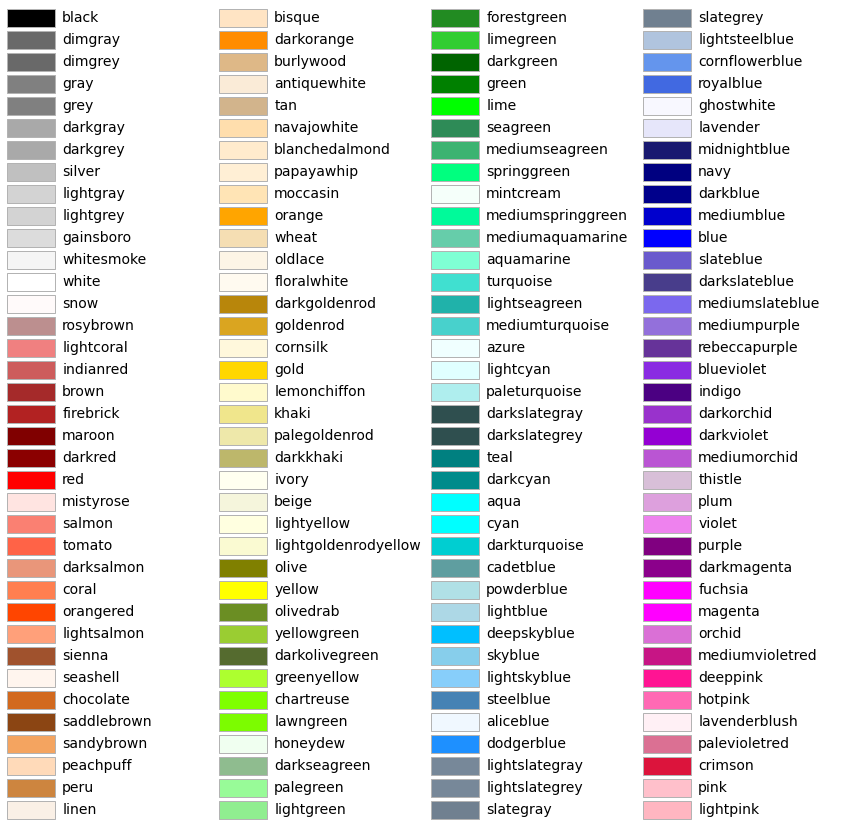

In [33]:
plot_colortable(mcolors.CSS4_COLORS)
plt.show()

In [35]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import rasterio.plot

In [37]:
def load_cmap(file_path = "data/color_map.json"):
    # Color map is https://collections.sentinel-hub.com/corine-land-cover/readme.html
    lc = json.load(open(file_path))
    lc_df = pd.DataFrame(lc)
    # lc_df["palette"] = "#" + lc_df["palette"]
    values = lc_df["values"].to_list()
    palette = lc_df["palette"].to_list()
    labels = lc_df["label"].to_list()

    # Create colormap from values and palette
    cmap = ListedColormap(palette)

    # Patches legend
    patches = [
        mpatches.Patch(color=palette[i], label=labels[i]) for i in range(len(values))
    ]
    legend = {
        "handles": patches,
        "bbox_to_anchor": (1.05, 1),
        "loc": 2,
        "borderaxespad": 0.0,
    }
    return cmap, legend

In [41]:
file_path = "../data/land_cover/selected/cropped_raster.tif"
with rasterio.open(file_path) as f:
    data = f.read(1)

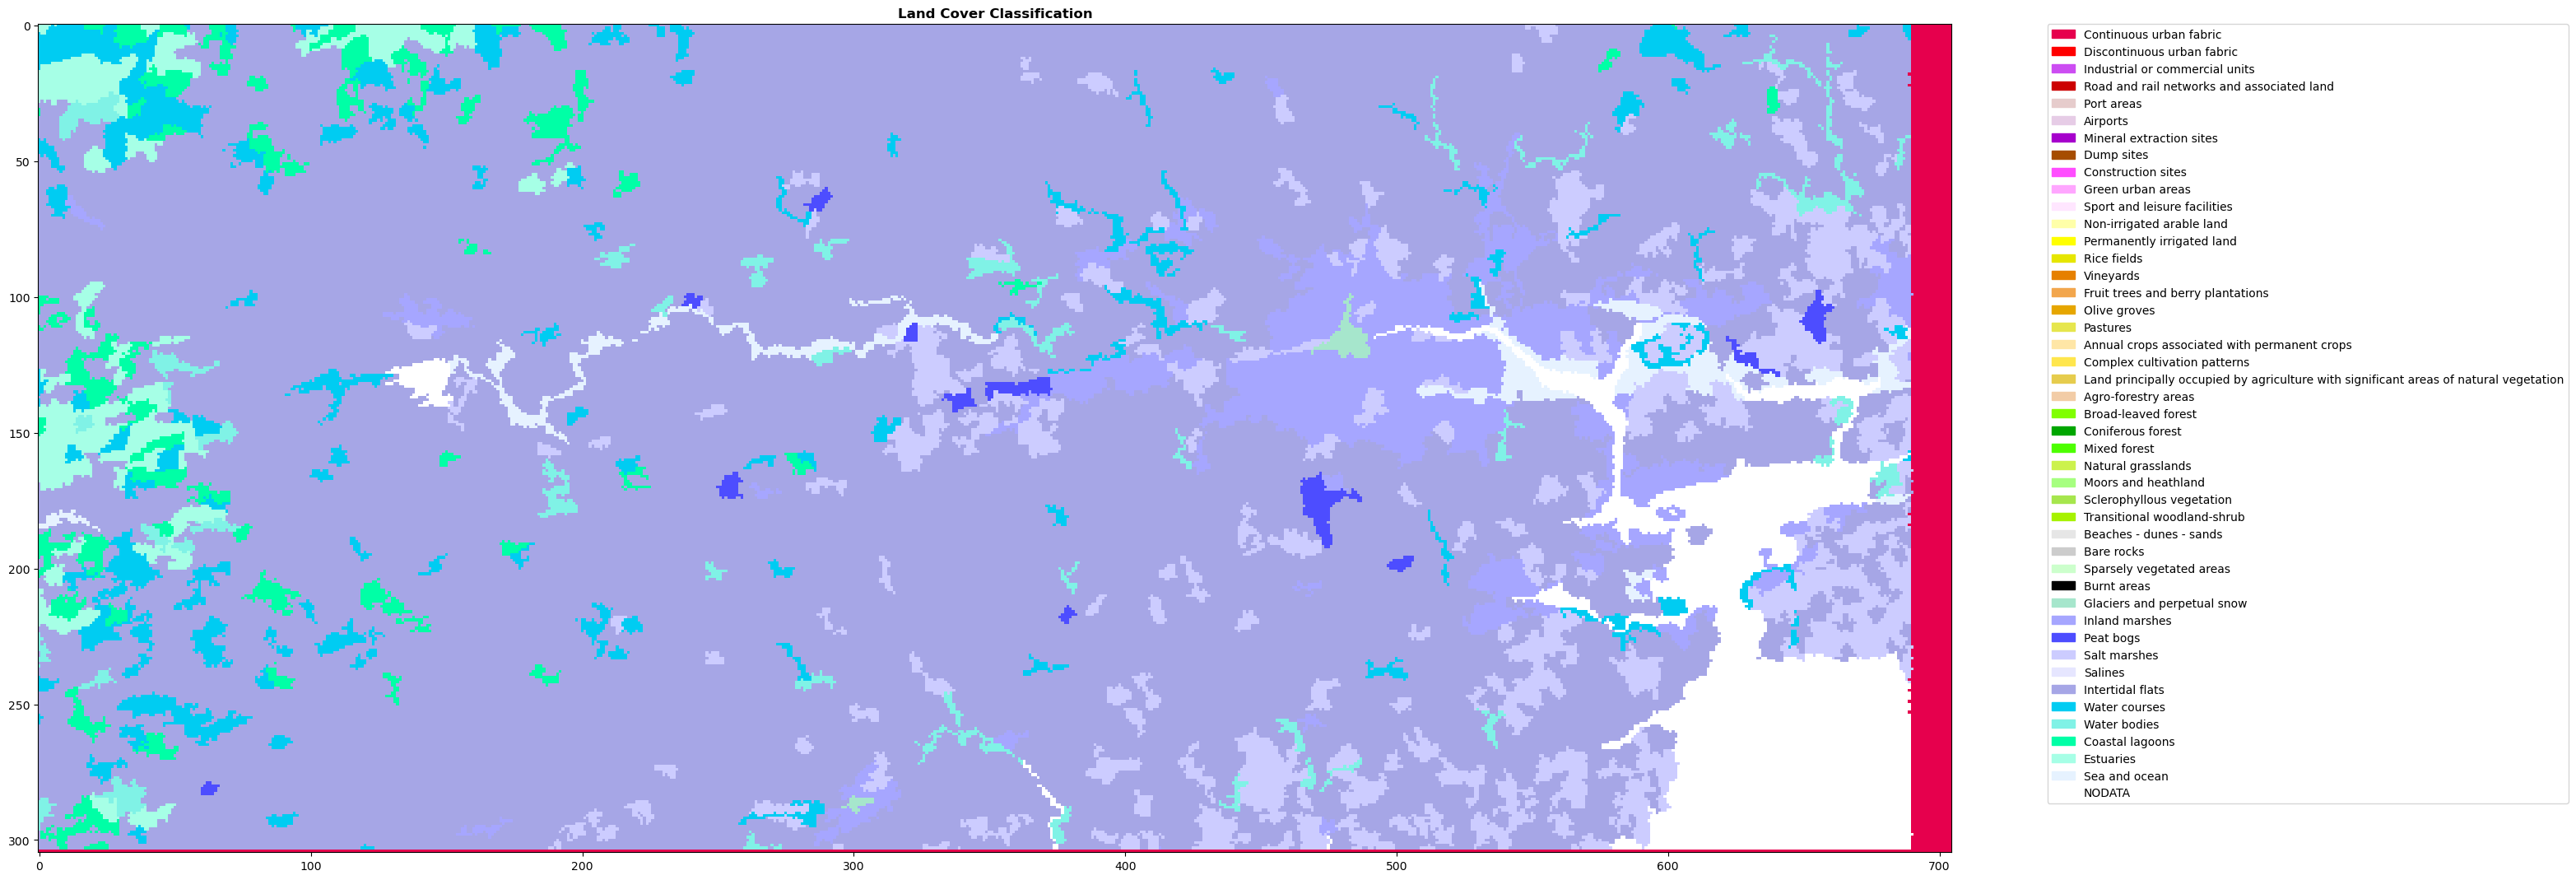

In [49]:
cmap, legend = load_cmap(file_path = "data/color_map.json")
fig, ax = plt.subplots(figsize=(30, 20))
ax.legend(**legend)
rasterio.plot.show(data, cmap=cmap, ax=ax, title='Land Cover Classification')
plt.show()

In [73]:
output_csv = "../data/land_cover/selected/data/output.csv"
output_df = pd.read_csv(output_csv, usecols=["CODE_18"])
output_df = output_df.rename(columns={"CODE_18": "predicted_label"})
output_df

,predicted_label
0,999
1,999
2,999
3,999
4,231
...,...
215020,999
215021,999
215022,999
215023,999


In [87]:
tes1 = output_df.to_numpy().ravel()
tes1.shape

(215025,)

In [89]:
test2 = output_df['predicted_label'].to_numpy()
test2.shape

(215025,)

In [91]:
tes1 == test2

array([ True,  True,  True, ...,  True,  True,  True])

In [69]:
output = output_df['predicted_label'].to_numpy()
output.shape

(215025,)

In [67]:
output.reshape((305, 705))

array([[999, 999, 999, ..., 999, 999, 231],
       [999, 243, 243, ..., 523, 523, 999],
       [999, 231, 243, ..., 523, 231, 999],
       ...,
       [999, 412, 412, ..., 324, 324, 999],
       [999, 412, 412, ..., 324, 324, 999],
       [999, 999, 999, ..., 999, 999, 999]], dtype=int64)

In [71]:
output.reshape((305, 705))

array([[999, 999, 999, ..., 999, 999, 231],
       [999, 243, 243, ..., 523, 523, 999],
       [999, 231, 243, ..., 523, 231, 999],
       ...,
       [999, 412, 412, ..., 324, 324, 999],
       [999, 412, 412, ..., 324, 324, 999],
       [999, 999, 999, ..., 999, 999, 999]], dtype=int64)